## Installing and Importing Required Libraries

In [ ]:
import torch
#!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 50.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-dv0ww2xi
  Running command git clone --filter=blob:none --quiet https://github.com/py

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import math
import os
import matplotlib.pyplot as plt
import string

import spacy
from spacy.tokens import Doc
from spacy import displacy
from scipy.sparse import coo_matrix

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, TransformerConv, GATv2Conv, ChebConv, ResGatedGraphConv
import torch_geometric.nn as pyg_nn
from torch_geometric.loader import DataLoader

## Reading training data

In [ ]:
df_train = pd.read_csv("/content/NewTrain.csvv")
df_train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,What am I losing when using extension tubes in...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,What is the distinction between a city and a s...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,Maximum protusion length for through-hole comp...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,Can an affidavit be used in Beit Din? An affid...,Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,How do you make a binary image in Photoshop? I...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [ ]:
df_test = pd.read_csv("/content/NewTest.csv")
df_test.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,Will leaving corpses lying around upset my pri...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,Url link to feature image in the portfolio I a...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","Is accuracy, recoil or bullet spread affected ...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,Suddenly got an I/O error from my external HDD...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,Passenger Name - Flight Booking Passenger only...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


In [ ]:
df_train.shape

(6079, 41)

In [ ]:
target_col_names = df_train.columns[-30:].tolist()
target_col_names

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

## Build a tokenizer and Graph Building

In [ ]:
class Tokenizer(object):
    def __init__(self, word2idx=None, nlp_model="en_core_web_sm"):
        # https://spacy.io/docs/usage/processing-text
        self.nlp = spacy.load(nlp_model)
        if word2idx is None:
            self.word2idx = {}
            self.idx2word = {}
            self.idx = 0
            self.word2idx['<pad>'] = self.idx  # '<pad>': 0
            self.idx2word[self.idx] = '<pad>'
            self.idx += 1
            self.word2idx['<unk>'] = self.idx  # '<unk>': 1
            self.idx2word[self.idx] = '<unk>'
            self.idx += 1
        else:
            self.word2idx = word2idx
            self.idx2word = {v:k for k,v in word2idx.items()}

    def fit_on_doc(self, doc:spacy.tokens.doc.Doc):
        for word in doc:
            word = str(word).lower()
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def text_to_doc(self, text):
        return self.nlp(text)

    def doc_to_sequence(self, doc:spacy.tokens.doc.Doc):
        sequence = []
        for w in doc:
            w = str(w).lower()
            word_id = self.word2idx.get(w, -1)
            if word_id == -1:
                word_id = self.word2idx['<unk>']
            sequence.append(word_id)
        if len(sequence) == 0:
            sequence = [0]
        return np.array(sequence, dtype=np.int32)

    def doc_to_adj(self, doc:spacy.tokens.doc.Doc):
        matrix = np.zeros((len(doc), len(doc))).astype('int32')
        for token in doc:
            for child in token.children:
                matrix[token.i][child.i] = 1
                matrix[child.i][token.i] = 1
        return matrix

In [ ]:
tokenizer = Tokenizer()

In [ ]:
idx2graph = {}
for i in tqdm(range(df_train.shape[0])):
    text = df_train.question_body[i].lower().replace("\n", "").strip()
    #text = cleanResume(text)
    doc = tokenizer.text_to_doc(text)
    tokenizer.fit_on_doc(doc)
    adj_matrix = tokenizer.doc_to_adj(doc)
    coo = coo_matrix(adj_matrix)
    idx2graph[i] = np.array([coo.row, coo.col], dtype=np.int32)

  0%|          | 0/6079 [00:00<?, ?it/s]

### example

In [ ]:
doc = tokenizer.text_to_doc("<pad> I like df <pad>")
tokenizer.doc_to_sequence(doc)

array([33744, 11355,   607,     4,    37, 11370, 33744, 11355,   607],
      dtype=int32)

In [ ]:
idx2graph[0]

array([[  0,   1,   2, ..., 358, 358, 359],
       [  3,   3,   3, ..., 356, 357, 332]], dtype=int32)

In [ ]:
idx2graph[0].shape

(2, 696)

In [ ]:
displacy.render(doc, style='dep', jupyter=True)

## Dataset Generation

In [ ]:
class MyTrainDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return "/kaggle/working/"

    @property
    def processed_dir(self):
        return os.path.join(self.root, "train_processed")

    @property
    def raw_file_names(self):
        return ['/kaggle/input/dataset1/NewTrain.csv']

    @property
    def processed_file_names(self):
        return ['train-data.pt']

    def download(self):
        pass

    def process(self):

        data_list = self.read_data()

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def read_data(self):
        df_train = pd.read_csv(self.raw_paths[0])
        all_data = []
        for i in range(df_train.shape[0]):
            text = df_train.question_body[i].lower().replace("\n", "").strip()
            #text = cleanResume(text)
            doc = tokenizer.text_to_doc(text)
            input_ids = tokenizer.doc_to_sequence(doc)
            label = df_train.loc[i,target_col_names].to_list()
            x = torch.tensor(input_ids.reshape(-1, 1), dtype=torch.int32)
            edge_index  = torch.tensor(idx2graph[i], dtype=torch.long)
            y = torch.tensor(np.array(label), dtype=torch.float32).reshape(-1, 30)
            data = Data(x=x, edge_index=edge_index, y=y)

            all_data.append(data)
        return all_data

In [ ]:
dataset = MyTrainDataset(root='/kaggle/working/')

Processing...
Done!


In [ ]:
dataset = dataset.shuffle()
train_len = int(0.8*len(dataset))
train_dataset = dataset[:train_len]
val_dataset = dataset[train_len:]
print(len(train_dataset), len(val_dataset))

4863 1216


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [ ]:
for i in train_loader:
    print(i)

DataBatch(x=[41488, 1], edge_index=[2, 80154], y=[128, 30], batch=[41488], ptr=[129])
DataBatch(x=[44117, 1], edge_index=[2, 85622], y=[128, 30], batch=[44117], ptr=[129])
DataBatch(x=[43619, 1], edge_index=[2, 84244], y=[128, 30], batch=[43619], ptr=[129])
DataBatch(x=[45218, 1], edge_index=[2, 87510], y=[128, 30], batch=[45218], ptr=[129])
DataBatch(x=[42674, 1], edge_index=[2, 82488], y=[128, 30], batch=[42674], ptr=[129])
DataBatch(x=[42594, 1], edge_index=[2, 82282], y=[128, 30], batch=[42594], ptr=[129])
DataBatch(x=[45487, 1], edge_index=[2, 88050], y=[128, 30], batch=[45487], ptr=[129])
DataBatch(x=[41556, 1], edge_index=[2, 80372], y=[128, 30], batch=[41556], ptr=[129])
DataBatch(x=[42758, 1], edge_index=[2, 82920], y=[128, 30], batch=[42758], ptr=[129])
DataBatch(x=[44632, 1], edge_index=[2, 86370], y=[128, 30], batch=[44632], ptr=[129])
DataBatch(x=[36058, 1], edge_index=[2, 69688], y=[128, 30], batch=[36058], ptr=[129])
DataBatch(x=[41134, 1], edge_index=[2, 79604], y=[128,

## Model Building

In [ ]:
unique_words=len(tokenizer.word2idx)

In [ ]:
from torch_geometric.nn import SAGEConv

In [ ]:
class FeedbackModel(nn.Module):
    def __init__(self):
        super(FeedbackModel, self).__init__()
        
        vocab_size=unique_words
        output_dims=300
        self.embed = nn.Embedding(vocab_size, output_dims)
        self.gc1 = SAGEConv(300, 128)
        self.pool1 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.gc2 = SAGEConv(128, 128)
        self.pool2 = pyg_nn.TopKPooling(128, ratio=0.8)
        self.gc3 = SAGEConv(128,128)
        self.lin1 = nn.Linear(256, 64)
        self.lin2 = nn.Linear(64, 30)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.squeeze(1)
        x = self.embed(x)
        
        x = F.relu(self.gc1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, batch=batch)
        x1 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.gc2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, batch=batch)
        x2 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.gc3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, batch=batch)
        x3 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

        x = x1 + x2 + x3
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        output = F.relu(self.lin2(x))

        return output


In [ ]:
model = FeedbackModel()
model

FeedbackModel(
  (embed): Embedding(99670, 300)
  (gc1): SAGEConv(300, 128, aggr=mean)
  (pool1): TopKPooling(128, ratio=0.8, multiplier=1.0)
  (gc2): SAGEConv(128, 128, aggr=mean)
  (pool2): TopKPooling(128, ratio=0.8, multiplier=1.0)
  (gc3): SAGEConv(128, 128, aggr=mean)
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=30, bias=True)
)

## Training SAGECONV Model

In [ ]:
epochs = 150

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6)

device = torch.device("cpu")
model.to(device)
criterion.to(device)

MSELoss()

In [ ]:
total_loss = []
for epoch_num in range(epochs):

    model.train()
    total_loss_train = 0
    for sample_batched in train_loader:
        sample_batched = sample_batched.to(device)
        optimizer.zero_grad()
        outputs = model(sample_batched)
        label = sample_batched.y.to(device)
        loss = criterion(outputs, label)
        loss.backward()
        total_loss_train += loss.item()
        optimizer.step()

    model.eval()
    total_loss_val = 0
    with torch.no_grad():
        for sample_batched in val_loader:
            sample_batched = sample_batched.to(device)
            outputs = model(sample_batched)
            label = sample_batched.y.to(device)
            loss = criterion(outputs, label)
            total_loss_val += loss.item()

    scheduler.step(total_loss_val / len(val_dataset))

    print(f'Epoch: %02.0f | Train Loss: {total_loss_train / len(train_dataset): .5f} | Val Loss: {total_loss_val / len(val_dataset): .5f}' % (epoch_num + 1))
    total_loss.append([total_loss_train / len(train_dataset), total_loss_val / len(val_dataset)])

Epoch: 01 | Train Loss:  0.00229 | Val Loss:  0.00231
Epoch: 02 | Train Loss:  0.00210 | Val Loss:  0.00208
Epoch: 03 | Train Loss:  0.00191 | Val Loss:  0.00183
Epoch: 04 | Train Loss:  0.00173 | Val Loss:  0.00158
Epoch: 05 | Train Loss:  0.00160 | Val Loss:  0.00138
Epoch: 06 | Train Loss:  0.00152 | Val Loss:  0.00126
Epoch: 07 | Train Loss:  0.00146 | Val Loss:  0.00119
Epoch: 08 | Train Loss:  0.00142 | Val Loss:  0.00115
Epoch: 09 | Train Loss:  0.00138 | Val Loss:  0.00109
Epoch: 10 | Train Loss:  0.00135 | Val Loss:  0.00104
Epoch: 11 | Train Loss:  0.00131 | Val Loss:  0.00099
Epoch: 12 | Train Loss:  0.00129 | Val Loss:  0.00096
Epoch: 13 | Train Loss:  0.00127 | Val Loss:  0.00092
Epoch: 14 | Train Loss:  0.00125 | Val Loss:  0.00090
Epoch: 15 | Train Loss:  0.00124 | Val Loss:  0.00088
Epoch: 16 | Train Loss:  0.00122 | Val Loss:  0.00087
Epoch: 17 | Train Loss:  0.00120 | Val Loss:  0.00085
Epoch: 18 | Train Loss:  0.00119 | Val Loss:  0.00084
Epoch: 19 | Train Loss:  0.0

In [ ]:
total_loss = np.array(total_loss, dtype=np.float32)

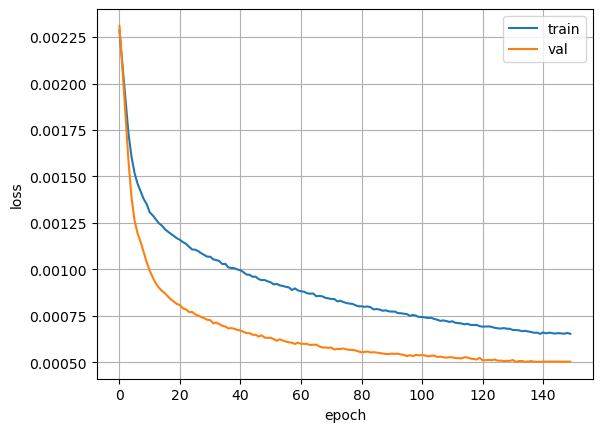

In [ ]:
plt.figure()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(total_loss[:,0], '-', label="train")
plt.plot(total_loss[:,1], '-', label="val")
plt.legend()
plt.grid(True)
plt.show()

## Performance Evaluation

In [ ]:
prediction = []
model.eval()
with torch.no_grad():
    for sample_batched in val_loader:
        sample_batched = sample_batched.to(device)
        outputs = model(sample_batched).detach().cpu().numpy()
        prediction.append(outputs)
prediction = np.concatenate(prediction)

In [ ]:
prediction.shape

(1216, 30)

In [ ]:
g=pd.DataFrame(prediction, columns=df_train.columns[-30:])

In [ ]:
l=list(g["question_conversational"].values)

In [ ]:
def calculate_mse(model, dataloader):
    mse = 0
    with torch.no_grad():
        for sample_batched in dataloader:
            sample_batched = sample_batched.to(device)
            outputs = model(sample_batched)
            #print(outputs.shape)
            label = sample_batched.y.to(device)
            mse += ((outputs - label)**2).mean().item()
    return mse / len(dataloader.dataset)

calculate_mse(model, val_loader)

0.0005027111068269924

In [ ]:
calculate_mse(model, train_loader)

0.0004588304470160506

In [ ]:
def calculate_r2(model, dataloader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for sample_batched in dataloader:
            sample_batched = sample_batched.to(device)
            outputs = model(sample_batched)
            label = sample_batched.y.to(device)
            y_true.extend(label.cpu().numpy())
            
            y_pred.extend(outputs.cpu().numpy())
        
    y_true = np.array(y_true) #[5,6,7]#one row 
    y_pred = np.array(y_pred) #[6,7,8]#one row 
    ss_res = ((y_true - y_pred)**2).sum() 
    ss_tot = ((y_true - y_true.mean())**2).sum()
    r2 = 1 - (ss_res / ss_tot)
    # print(y_true.shape)
    # print(y_pred.shape)
    return r2


calculate_r2(model, val_loader)

0.6441478431224823

In [ ]:
calculate_r2(model, train_loader)

0.6570224761962891

In [ ]:
class MyTestDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return "/kaggle/input/modified-google-quest"

    @property
    def processed_dir(self):
        return os.path.join(self.root, "test_processed")
    
    @property
    def raw_file_names(self):
        return ['NewTest.csv']

    @property
    def processed_file_names(self):
        return ['test-data.pt']

    def download(self):
        pass

    def process(self):

        data_list = self.read_data()

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def read_data(self):
        df_test = pd.read_csv(self.raw_paths[0])
        all_data = []
        for i in range(df_test.shape[0]):
            text = df_test.question_body[i].lower().replace("\n", "").strip()
            doc = tokenizer.text_to_doc(text)
            input_ids = tokenizer.doc_to_sequence(doc)

            x = torch.tensor(input_ids.reshape(-1, 1), dtype=torch.int32)
            edge_index  = torch.tensor(test_idx2graph[i], dtype=torch.long)
            data = Data(x=x, edge_index=edge_index)

            all_data.append(data)
        return all_data

In [ ]:
test_dataset = MyTestDataset(root='/kaggle/working/')

Processing...
Done!


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=128)

In [ ]:
prediction = []
model.eval()
with torch.no_grad():
    for sample_batched in test_loader:
        sample_batched = sample_batched.to(device)
        outputs = model(sample_batched).detach().cpu().numpy()
        prediction.append(outputs)
prediction = np.concatenate(prediction)

In [ ]:
pred_cols=df_train.columns[-30:]
col = pd.concat([df_train['question_body'], pred_cols], axis=1)

In [ ]:
submission = pd.DataFrame(
    data=prediction,
    index=df_test.qa_id,
    columns=col).reset_index()
submission.head()

,qa_id,question_body,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,I see questions/information online about how t...,0.856624,0.580484,0,0.575751,0.714041,0.636232,0.608643,0.516538,...,0.799809,0.858994,0.521074,0.947188,0.908135,0.755710,0.325913,0.000000,0.600436,0.813440
1,46,I am new to Wordpress. i have issue with Featu...,0.892445,0.574393,0,0.684056,0.711029,0.748882,0.543234,0.483077,...,0.733278,0.848092,0.650018,0.897967,0.895094,0.862195,0.416769,0.000000,0.509254,0.820735
2,70,"To experiment I started a bot game, toggled in...",0.838212,0.633049,0,0.686989,0.748824,0.764776,0.552243,0.460870,...,0.809791,0.924300,0.607432,0.856148,0.944101,0.816101,0.436777,0.000000,0.415623,0.853636
3,132,I have used my Raspberry Pi as a torrent-serve...,0.897682,0.581682,0,0.753373,0.844856,0.941121,0.616089,0.557795,...,0.784911,1.041214,0.798175,0.981161,1.059767,0.932612,0.702079,0.048403,0.424309,0.991175
4,200,I have bought Delhi-London return flights for ...,0.769170,0.573199,0,0.645145,0.669436,0.633335,0.542402,0.441566,...,0.701190,0.830111,0.540561,0.753725,0.850427,0.729222,0.366707,0.000000,0.451908,0.802878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,9569,I am using gb4e for glossing examples in my th...,0.803142,0.588411,0,0.740808,0.815249,0.857870,0.544958,0.477744,...,0.722894,0.950332,0.700857,0.870805,0.921798,0.784444,0.547107,0.088950,0.390841,0.817720
472,9590,Source : Microsoft Interview Question\n\nWe ar...,0.776304,0.533631,0,0.703637,0.753560,0.904070,0.485077,0.347539,...,0.608377,0.858348,0.698110,0.860640,0.892461,0.769591,0.730102,0.177098,0.222358,0.749262
473,9597,I am creating a time series database that foll...,0.784833,0.484141,0,0.650358,0.727458,0.787339,0.554502,0.450819,...,0.746482,0.816197,0.626989,0.888608,0.884617,0.838776,0.523373,0.000000,0.448919,0.849086
474,9623,If I flashback Past in Flames and it is counte...,0.853544,0.561112,0,0.669363,0.721675,0.754590,0.556912,0.471004,...,0.767945,0.882833,0.625930,0.880796,0.967866,0.830751,0.442274,0.000000,0.471809,0.906141


In [ ]:
submission.to_csv("submission.csv",index=False)